# 1. 해양사고 종류

해양사고에는 다양한 종류가 존재한다. 대표적인 예시로는<br>충돌, 전복, 침몰, 화재폭발, 안전사고, 접촉, 좌초 등 여러 종류가 존재

# 2. 해양사고 데이터 불러오기

2023년 발생한 해양사고 데이터를 불러오도록 해본다.<br>
데이터는 해양교통안전정보시스템 mtis의 gis기반 사고 분석 데이터를 활용한다.

## 2-1. setup을 위한 library 불러오기

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import math


## 2-2. data불러오기

In [3]:
shipwreck = pd.read_excel("C:/Users/GBOOK/python projects/MarineSeaProject/gis기반 사고 현황_202407291433.xlsx")
shipwreck.head()

,사건명,사고발생일시,사고종류,안전사고유형,사망자,실종자,사망실종자,부상자,해역,선박용도(통계),선박용도(대),선박용도(중),선박용도(소),선박톤수,톤수(통계),위도,경도
0,어선 대명호 기관손상사건,2023-12-31 16:18,기관손상,NaN,0,0,0,0,동해영해,어선,어선,연안어업선,연안복합어업,1.72,2톤 미만,35.292,129.342
1,어선 고고씽호 기관손상사건,2023-12-31 11:31,기관손상,NaN,0,0,0,0,동해영해,어선,어선,연안어업선,연안자망어업,4.99,2톤~5톤 미만,36.338,129.396
2,어선 세진9호 침수사건,2023-12-31 08:15,침수,NaN,0,0,0,0,서해영해,어선,어선,기타어업선,양식장관리선,1.18,2톤 미만,34.266,126.343
3,어선 만석호 추진축계손상사건,2023-12-31 02:35,추진축계손상,NaN,0,0,0,0,동해공해,어선,어선,연안어업선,연안통발어업,9.77,5톤~10톤 미만,36.567,129.833
4,어선 제88영신호 선원사망사건,2023-12-31 00:24,안전사고,구조물∙줄 등의 신체가격,1,0,1,0,동해공해,어선,어선,근해어업선,근해통발어업,89.00,20톤~100톤 미만,35.683,130.583


In [4]:
# 데이터프레임 정보 확인하기
# shipwreck.info()
# 총 3416개의 사고가 존재한다.

## 2-3. 위도, 경도 한계치 설정

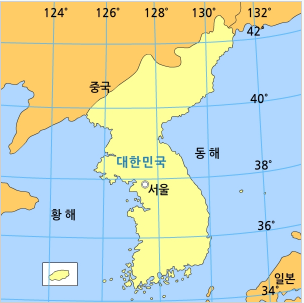
> latitude 32 - 42, longitude 124 - 134

위도 한계치를 설정하는 이유
- 해양사고 발생현황 데이터의 위치가 크게 벗어난 데이터는 제외한다.
- 가능한 한반도 인근 해역에서 발생한 데이터 위주로 확인한다.

In [5]:
min_lat = 32.0
min_long = 124.0
max_lat = 42.0
max_long = 134.0

shipwreck = shipwreck[
    (shipwreck['위도'] >= min_lat) &
    (shipwreck['위도'] <= max_lat) &
    (shipwreck['경도'] >= min_long) &
    (shipwreck['경도'] <= max_long)
]

이제 불러온 데이터를 위도 경도를 geometry 정보로 변환 후 GeoDataFrame 으로 변경

In [6]:
# shipwreck 데이터의 x, y geometry 정보를 만들어주기 위해 경도와 위도를 변경
shipwreck['geometry'] = shipwreck.apply(lambda row: Point([row['경도'], row['위도']]), axis=1)
shipwreck = gpd.GeoDataFrame(shipwreck, geometry='geometry')
shipwreck.head()

# 데이터가 GeoDataFrame으로 변경이 되었다면, 일단 1차적인 준비는 끝

,사건명,사고발생일시,사고종류,안전사고유형,사망자,실종자,사망실종자,부상자,해역,선박용도(통계),선박용도(대),선박용도(중),선박용도(소),선박톤수,톤수(통계),위도,경도,geometry
0,어선 대명호 기관손상사건,2023-12-31 16:18,기관손상,NaN,0,0,0,0,동해영해,어선,어선,연안어업선,연안복합어업,1.72,2톤 미만,35.292,129.342,POINT (129.342 35.292)
1,어선 고고씽호 기관손상사건,2023-12-31 11:31,기관손상,NaN,0,0,0,0,동해영해,어선,어선,연안어업선,연안자망어업,4.99,2톤~5톤 미만,36.338,129.396,POINT (129.396 36.338)
2,어선 세진9호 침수사건,2023-12-31 08:15,침수,NaN,0,0,0,0,서해영해,어선,어선,기타어업선,양식장관리선,1.18,2톤 미만,34.266,126.343,POINT (126.343 34.266)
3,어선 만석호 추진축계손상사건,2023-12-31 02:35,추진축계손상,NaN,0,0,0,0,동해공해,어선,어선,연안어업선,연안통발어업,9.77,5톤~10톤 미만,36.567,129.833,POINT (129.833 36.567)
4,어선 제88영신호 선원사망사건,2023-12-31 00:24,안전사고,구조물∙줄 등의 신체가격,1,0,1,0,동해공해,어선,어선,근해어업선,근해통발어업,89.00,20톤~100톤 미만,35.683,130.583,POINT (130.583 35.683)


# 3. 행정경계 데이터 불러오기

### 행정경계를 불러와서 만들기에는 부적합하다고 판단하여 실행X

# 3-2. folium map 이용

In [7]:
# 지도 그리기
m_1 = folium.Map(location=[36.567, 127.9367], tiles='cartodbpositron', zoom_start=7)

# 해양사고 데이터 포인트로 점 찍기
for idx, row in shipwreck.iterrows():
    Marker([row['위도'], row['경도']]).add_to(m_1)
    
# m_1

In [8]:
m_2 = folium.Map(location=[36.567, 127.9367], tiles='cartodbpositron', zoom_start=7)

mc = MarkerCluster()
for idx, row in shipwreck.iterrows():
    if not math.isnan(row['경도']) and not math.isnan(row['위도']):
        mc.add_child(Marker([row['위도'], row['경도']]))
m_2.add_child(mc)

# github webpage
m_2.save("m_2.html")

m_2    

## 4. 사망자가 발생한 데이터만 불러오기

shipwreck 데이터프레임 중에서 사망자 >= 1 인 데이터만 추출

In [9]:
shipwreck = shipwreck[(shipwreck['사망자'] >= 1)]
shipwreck.head()

,사건명,사고발생일시,사고종류,안전사고유형,사망자,실종자,사망실종자,부상자,해역,선박용도(통계),선박용도(대),선박용도(중),선박용도(소),선박톤수,톤수(통계),위도,경도,geometry
4,어선 제88영신호 선원사망사건,2023-12-31 00:24,안전사고,구조물∙줄 등의 신체가격,1,0,1,0,동해공해,어선,어선,근해어업선,근해통발어업,89.00,20톤~100톤 미만,35.683,130.583,POINT (130.583 35.683)
39,어선 유진호 전복사건,2023-12-27 11:25,전복,NaN,1,0,1,0,서해영해,어선,어선,연안어업선,연안통발어업,9.77,5톤~10톤 미만,35.400,125.800,POINT (125.8 35.4)
90,모터보트 여수호 조종자사망사건,2023-12-20 20:05,안전사고,실족∙파도 등으로 해상추락,1,0,1,0,남해영해,수상레저기구,수상레저기구,레저기구,모터보트,1.43,2톤 미만,34.727,127.737,POINT (127.737 34.727)
91,부선 극동비-1호 침몰사건,2023-12-20 19:27,침몰,NaN,1,0,1,0,무역항 및 진입수로,기타선,기타선,내항 부선,공사작업용부선,531.00,500톤~1000톤 미만,37.458,126.601,POINT (126.601 37.458)
102,어선 제99부영호 선원사망사건,2023-12-19 06:36,안전사고,구조물∙줄 등의 신체가격,1,0,1,0,동해공해,어선,어선,연안어업선,연안자망어업,9.77,5톤~10톤 미만,35.683,129.883,POINT (129.883 35.683)


In [10]:
# shipwreck.info()
# 총 60건으로 줄어들었다

In [11]:
shipwreck_counts = shipwreck['사망자'].value_counts()
print(shipwreck_counts)

사망자
1    59
4     1
5     1
Name: count, dtype: int64


In [12]:
shipwreck

,사건명,사고발생일시,사고종류,안전사고유형,사망자,실종자,사망실종자,부상자,해역,선박용도(통계),선박용도(대),선박용도(중),선박용도(소),선박톤수,톤수(통계),위도,경도,geometry
4,어선 제88영신호 선원사망사건,2023-12-31 00:24,안전사고,구조물∙줄 등의 신체가격,1,0,1,0,동해공해,어선,어선,근해어업선,근해통발어업,89.00,20톤~100톤 미만,35.683,130.583,POINT (130.583 35.683)
39,어선 유진호 전복사건,2023-12-27 11:25,전복,NaN,1,0,1,0,서해영해,어선,어선,연안어업선,연안통발어업,9.77,5톤~10톤 미만,35.400,125.800,POINT (125.8 35.4)
90,모터보트 여수호 조종자사망사건,2023-12-20 20:05,안전사고,실족∙파도 등으로 해상추락,1,0,1,0,남해영해,수상레저기구,수상레저기구,레저기구,모터보트,1.43,2톤 미만,34.727,127.737,POINT (127.737 34.727)
91,부선 극동비-1호 침몰사건,2023-12-20 19:27,침몰,NaN,1,0,1,0,무역항 및 진입수로,기타선,기타선,내항 부선,공사작업용부선,531.00,500톤~1000톤 미만,37.458,126.601,POINT (126.601 37.458)
102,어선 제99부영호 선원사망사건,2023-12-19 06:36,안전사고,구조물∙줄 등의 신체가격,1,0,1,0,동해공해,어선,어선,연안어업선,연안자망어업,9.77,5톤~10톤 미만,35.683,129.883,POINT (129.883 35.683)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3182,어선 청보호 전복사건,2023-02-04 23:22,전복,NaN,5,4,9,0,서해영해,어선,어선,근해어업선,근해통발어업,24.00,20톤~100톤 미만,35.212,125.721,POINT (125.721 35.212)
3215,어선 해성호 선원사망사건,2023-01-31 11:30,안전사고,어구∙줄에 감겨 해상추락,1,0,1,0,남해영해,어선,어선,연안어업선,연안복합어업,9.77,5톤~10톤 미만,34.005,126.743,POINT (126.743 34.005)
3353,냉동운반선 조나단스타 선원사망사건,2023-01-08 11:18,안전사고,어창∙사다리 등 선내추락,1,0,1,0,남해영해,화물선,화물선,외항 화물선,냉동운반선,4394.00,1000톤~5000톤 미만,33.667,126.917,POINT (126.917 33.667)
3401,무등록선박 선원사망사건,2023-01-02 15:29,안전사고,목격자 없는 사망∙실종,1,0,1,0,서해영해,수상레저기구,수상레저기구,레저기구,모터보트,0.50,2톤 미만,35.005,126.264,POINT (126.264 35.005)


In [13]:
m_2 = folium.Map(location=[36.567, 127.9367], tiles='cartodbpositron', zoom_start=7)

mc = MarkerCluster()
for idx, row in shipwreck.iterrows():
    if not math.isnan(row['경도']) and not math.isnan(row['위도']):
        mc.add_child(Marker([row['위도'], row['경도']], popup=row['사고종류']))
m_2.add_child(mc)

m_2
        

In [24]:
popup_html_template = '''
    <div style="width: 200px; height: 100px; overflow: auto; border: 1px solid black; padding: 5px;">
        <p style="margin: 0; word-wrap: break-word;">{}</p>
    </div>
'''
m_2 = folium.Map(location=[36.567, 127.9367], tiles='cartodbpositron', zoom_start=7)

mc = MarkerCluster()
for idx, row in shipwreck.iterrows():
    if not math.isnan(row['경도']) and not math.isnan(row['위도']):
        popup_html = popup_html_template.format(row['사건명'])
        popup = folium.Popup(popup_html, max_width=300)  # max_width를 조정하여 팝업 너비 설정
        mc.add_child(Marker([row['위도'], row['경도']], popup=popup))
        
m_2.add_child(mc)

m_2
        

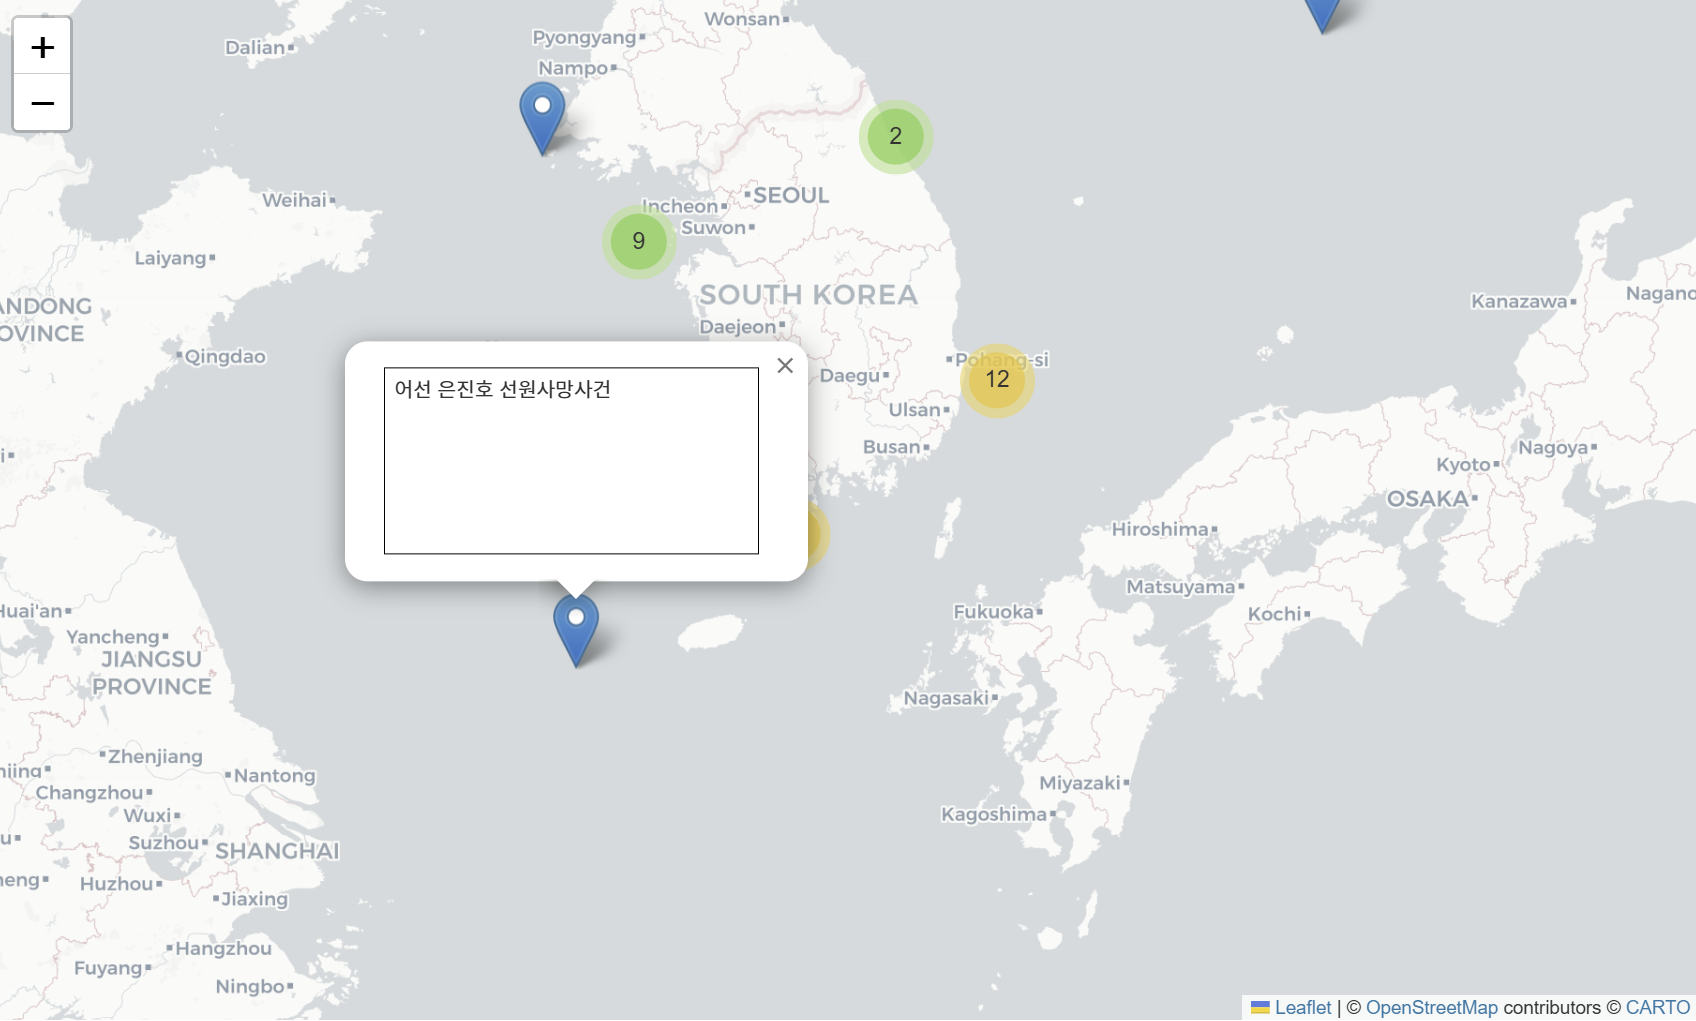

folium 맵으로 표현한 해양 사망사고 지도